In [1]:
import torch.nn.functional as F
from torchvision import transforms 
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
from torch import nn
import math
from torch.optim import AdamW
import tqdm

from useful_functions_notebook_14to18 import *

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet()

generator_path = "../notebooks/models/fox_attempt1/generator_fox_test.pt"
encoder_path = "../notebooks/models/fox_attempt1/encoder_fox_test.pt"

saved_generator = torch.load(generator_path, map_location = device)
generator_state_dict = saved_generator["generator"]
latent_dim = saved_generator["latent_space"]
num_branches = saved_generator["num_branches"]
nvar = saved_generator["nvar"]

generator = Generator(nvar, num_branches, latent_dim)
generator.load_state_dict(generator_state_dict)

saved_encoder = torch.load(encoder_path, map_location = device)
encoder_state_dict = saved_encoder["encoder"]

encoder = Encoder(nvar, num_branches, latent_dim)
encoder.load_state_dict(encoder_state_dict)

for param in generator.parameters():
    param.requires_grad = False
    
for param in encoder.parameters():
    param.requires_grad = False

orignal sample:
torch.Size([5, 3, 29, 10])


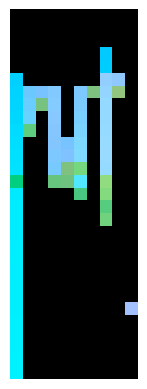

latent representation:
torch.Size([5, 300])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed sample:
torch.Size([5, 3, 29, 10])


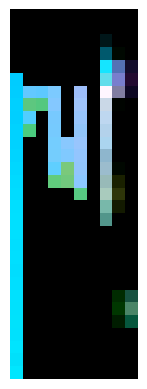

In [3]:
data_path = "data/dataset_distlognorm_massnorm.pt"
data = torch.load(data_path)
sample = data[1237:1237 + 5]
print("orignal sample:")
print(sample.shape)
plt.imshow(sample[0].detach().permute(1, 2, 0))
plt.axis('off')  # Optional: Turn off axis ticks and labels
plt.show()

latent = encoder(sample.to(dtype=torch.float32))
print("latent representation:")
print(latent.shape)
plt.imshow(latent.detach())
plt.axis('off')  # Optional: Turn off axis ticks and labels
plt.show()


recon = generator(latent)

print("reconstructed sample:")
print(recon.shape)
plt.imshow(recon[0].detach().permute(1, 2, 0))
plt.axis('off')  # Optional: Turn off axis ticks and labels
plt.show()


In [5]:

def train(dataloader, epochs, bs, img_size, lr, device):
    model = UNet().to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    mse = nn.MSELoss()
    diffusion = Diffusion(T = T, img_size=img_size, device=device)
    l = len(dataloader)

    loss_list = []
    for epoch in range(epochs):
        pbar = tqdm.tqdm(dataloader)
        loss_epoch = 0.0
        for i, images in enumerate(pbar):
            images = images.to(dtype=torch.float32)
            images = images.to(device)
            t = diffusion.sample_timesteps(images.shape[0]).to(device)
            x_t, noise = diffusion.noise_images(images, t)
            x_t, noise = x_t.to(device), noise.to(device)
            predicted_noise = model(x_t, t).to(device)
            loss = mse(noise, predicted_noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_epoch += loss.item()

        loss_list.append(loss_epoch / len(dataloader))
        sampled_images = diffusion.sample(model, n=1)
        
        if epoch % 10 == 0:
            if fox:
                model_name = "/fp/projects01/ec35/homes/ec-corneb/diffusion/fox1/diffusion_new_model2.0.pt"
            else:
                model_name = "../notebooks/diffusion_notebook/T&E1000/epoch1000/diffusion_test.pt"
            torch.save(model.state_dict(), model_name)

        print(f"Epoch {epoch + 1} | Loss: {loss.item()} ")
        
    return loss_list, sampled_images, model

In [6]:
def diffusion_train_epoch(images, diffusion, model, optimizer, mse, device):
    t = diffusion.sample_timesteps(images.shape[0]).to(device)
    x_t, noise = diffusion.noise_images(images, t)
    x_t, noise = x_t.to(device), noise.to(device)
    predicted_noise = model(x_t, t).to(device)
    loss = mse(noise, predicted_noise)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return predicted_noise, loss, diffusion, model

def training_latent_diffusion(encoder, generator, latent_diffusion_model, dataloader,
                              num_epochs, lr, T, device, pretrained = True):
    
    encoder, generator, latent_diffusion_model = encoder.to(device), generator.to(device), latent_diffusion_model.to(device)
    optimizer = AdamW(latent_diffusion_model.parameters(), lr = lr)
    mse = nn.MSELoss()
    diffusion = Diffusion(T = T, img_size=img_size, device=device)
    l = len(dataloader)
    
    transform = transforms.Resize((64, 64))
    transform_back = transforms.Resize((10, 10))

    for epoch in range(num_epochs):
        print(f"Epoch: {epoch + 1} / {num_epochs}")
        
        for batch in tqdm.tqdm(dataloader):
            print("input:", batch.shape)
            # (bs, 3, 29, 10)
            #print("should be (bs, 3, 29, 10):", batch.shape)
            batch = batch.to(dtype=torch.float32).to(device)
            
            # run through encoder
            # (bs, 300)
            latent_representation = encoder(batch)
            print("encoder output:", latent_representation.shape)
            #print("should be (bs, 300):",latent_representation.shape)
            # reshape
            # (bs, 3, 10, 10)
            latent_review = latent_representation.view(-1, 3, 10, 10)
            #print("should be (bs, 3, 10, 10):", latent_review.shape)
            print("view:", latent_review.shape)
            # (bs, 3, 64, 64)
            latent_reshape = transform(latent_review)
            #print("should be (bs, 3, 64, 64):", latent_reshape.shape)
            print("reshape:", latent_reshape.shape)
            
            #run through diffusion
            # (bs, 3, 64, 64)
            latent_diffused, loss, diffusion, latent_diffusion_model = diffusion_train_epoch(latent_reshape,
                                                                                             diffusion,
                                                                                             latent_diffusion_model,
                                                                                             optimizer,
                                                                                             mse,
                                                                                             device)
            #print("should be (bs, 3, 64, 64):", latent_diffused.shape)
            print("diffusion output:", latent_diffused.shape)
            
            #reshape
            # (bs, 3, 10, 10)
            latent_out = transform_back(latent_diffused)
            print("reshape back:", latent_out.shape)
            #print("should be (bs, 3, 10, 10):", latent_out.shape)
            # (bs, 300)
            latent_out_view = latent_out.reshape(-1, 300)
            print("view back:", latent_out_view.shape)
            #print("should be (bs, 300):", latent_out_view.shape)
            #run through generator
            output = generator(latent_out_view)
            print("generator output:", output.shape)
            #print("should be (bs, 3, 29, 10):", output.shape)
            
        print(f"Epoch {epoch + 1} | Loss: {loss.item()} ")
        
        
        plt.imshow(batch[0].detach().permute(1, 2, 0))
        plt.axis('off')  # Optional: Turn off axis ticks and labels
        plt.show()

        plt.imshow(latent_reshape[0].detach().permute(1, 2, 0))
        plt.axis('off')  # Optional: Turn off axis ticks and labels
        plt.show()

        plt.imshow(latent_diffused[0].detach().permute(1, 2, 0))
        plt.axis('off')  # Optional: Turn off axis ticks and labels
        plt.show()

        plt.imshow(output[0].detach().permute(1, 2, 0))
        plt.axis('off')  # Optional: Turn off axis ticks and labels
        plt.show()
        
    return encoder, generator, latent_diffusion_model
            

Epoch: 1 / 5


  0%|                                                     | 0/1 [00:00<?, ?it/s]

input: torch.Size([1, 3, 29, 10])
encoder output: torch.Size([1, 300])
view: torch.Size([1, 3, 10, 10])
reshape: torch.Size([1, 3, 64, 64])


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.
/Users/corneliusbencsik/anaconda3/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.43s/it]

diffusion output: torch.Size([1, 3, 64, 64])
reshape back: torch.Size([1, 3, 10, 10])
view back: torch.Size([1, 300])
generator output: torch.Size([1, 3, 29, 10])
Epoch 1 | Loss: 1.3637136220932007 


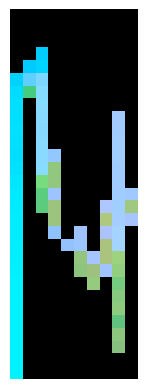

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


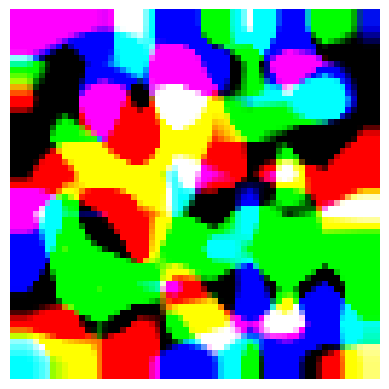

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


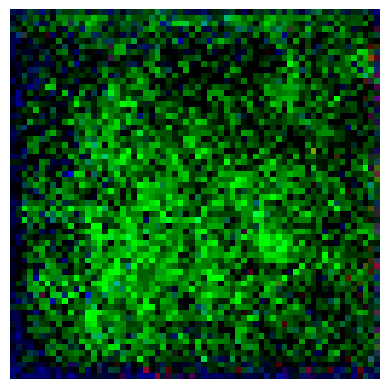

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


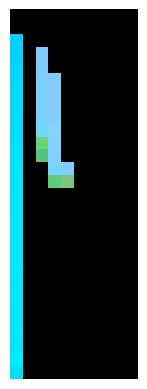

Epoch: 2 / 5


  0%|                                                     | 0/1 [00:00<?, ?it/s]

input: torch.Size([1, 3, 29, 10])
encoder output: torch.Size([1, 300])
view: torch.Size([1, 3, 10, 10])
reshape: torch.Size([1, 3, 64, 64])


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.24s/it]

diffusion output: torch.Size([1, 3, 64, 64])
reshape back: torch.Size([1, 3, 10, 10])
view back: torch.Size([1, 300])
generator output: torch.Size([1, 3, 29, 10])
Epoch 2 | Loss: 2.76387882232666 


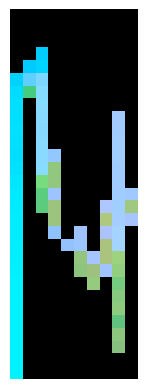

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


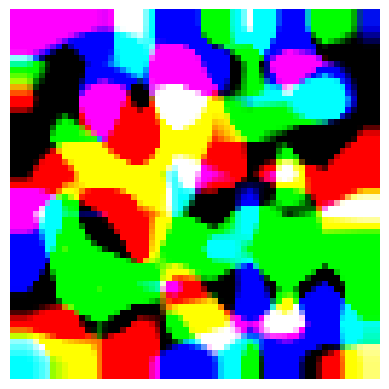

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


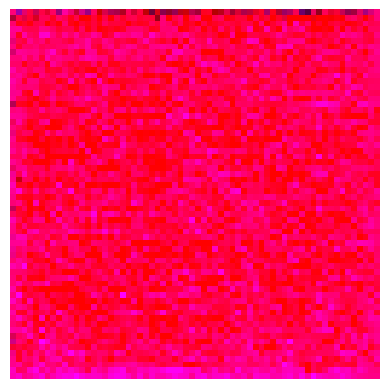

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


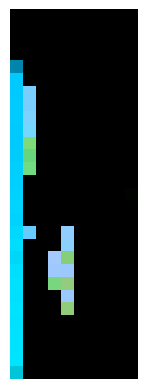

Epoch: 3 / 5


  0%|                                                     | 0/1 [00:00<?, ?it/s]

input: torch.Size([1, 3, 29, 10])
encoder output: torch.Size([1, 300])
view: torch.Size([1, 3, 10, 10])
reshape: torch.Size([1, 3, 64, 64])


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.09s/it]

diffusion output: torch.Size([1, 3, 64, 64])
reshape back: torch.Size([1, 3, 10, 10])
view back: torch.Size([1, 300])
generator output: torch.Size([1, 3, 29, 10])
Epoch 3 | Loss: 1.133017897605896 


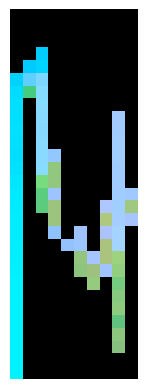

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


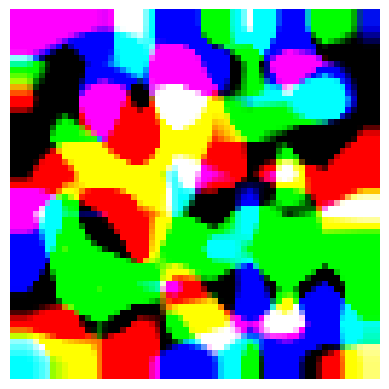

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


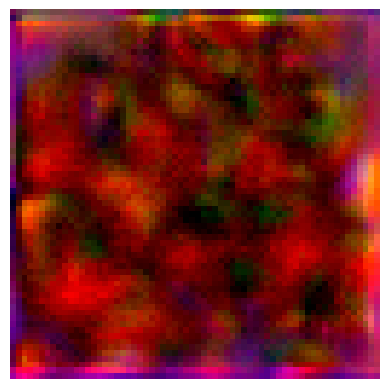

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


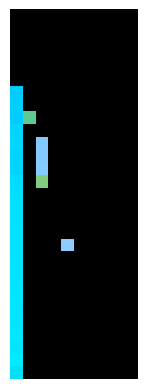

Epoch: 4 / 5


  0%|                                                     | 0/1 [00:00<?, ?it/s]

input: torch.Size([1, 3, 29, 10])
encoder output: torch.Size([1, 300])
view: torch.Size([1, 3, 10, 10])
reshape: torch.Size([1, 3, 64, 64])


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.17s/it]

diffusion output: torch.Size([1, 3, 64, 64])
reshape back: torch.Size([1, 3, 10, 10])
view back: torch.Size([1, 300])
generator output: torch.Size([1, 3, 29, 10])
Epoch 4 | Loss: 1.0791633129119873 


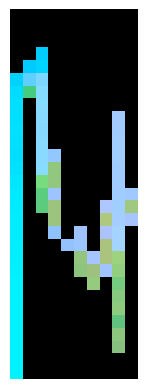

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


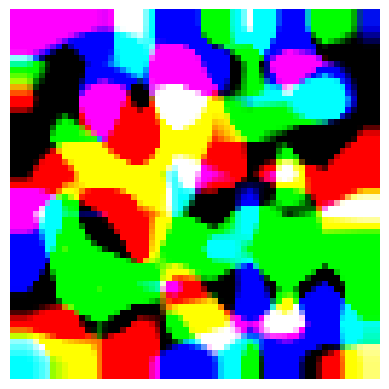

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


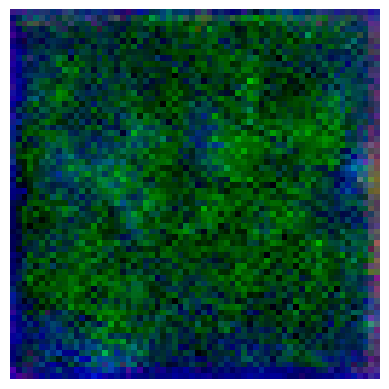

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


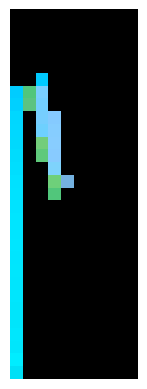

Epoch: 5 / 5


  0%|                                                     | 0/1 [00:00<?, ?it/s]

input: torch.Size([1, 3, 29, 10])
encoder output: torch.Size([1, 300])
view: torch.Size([1, 3, 10, 10])
reshape: torch.Size([1, 3, 64, 64])


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.99s/it]

diffusion output: torch.Size([1, 3, 64, 64])
reshape back: torch.Size([1, 3, 10, 10])
view back: torch.Size([1, 300])
generator output: torch.Size([1, 3, 29, 10])
Epoch 5 | Loss: 1.0864390134811401 


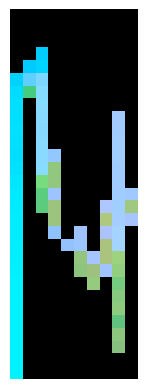

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


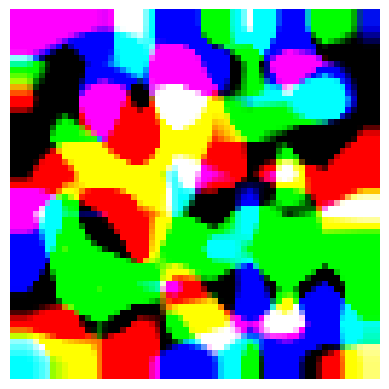

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


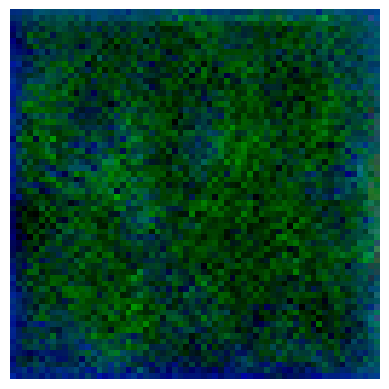

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


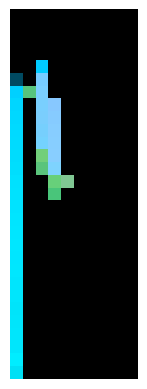

In [7]:
transform = transforms.Resize((64, 64))
transform_back = transforms.Resize((10, 10))

batch_size = 1
T = 1000
img_size = 64
lr = 3e-4

epochs = 5
dataloader = DataLoader(data[:batch_size], batch_size = batch_size, shuffle = True)

encoder, generator, latent_diffusion_model = training_latent_diffusion(encoder, generator, model, dataloader,
                                                                      epochs, lr, T, device, pretrained = True)

# Generate

In [8]:
latent_diffusion_model = UNet()
generator = Generator(nvar, num_branches, latent_dim)

latent_diffusion_path = "../notebooks/diffusion_notebook/latent_diffusion/2.0/latent_diffusion_model2.0.pt"
generator_path = "../notebooks/diffusion_notebook/latent_diffusion/2.0/generator_model2.0.pt"

saved_generator_model1 = torch.load(generator_path, map_location = device)
generator.load_state_dict(saved_generator_model1)

saved_latent_model1 = torch.load(latent_diffusion_path, map_location = device)
latent_diffusion_model.load_state_dict(saved_latent_model1)

<All keys matched successfully>

/var/folders/th/xzh64xy15874rx6gs9kn93qw0000gn/T/ipykernel_78707/815485143.py:50: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize)+1)


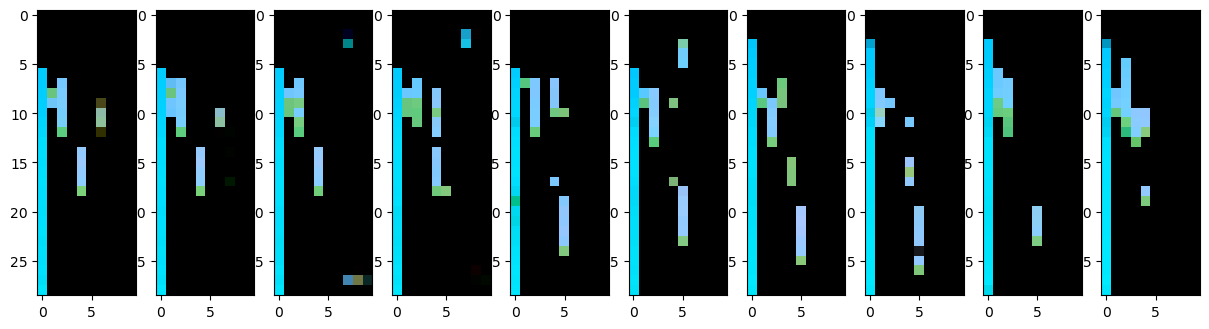

In [16]:
@torch.no_grad()
def sample_timestep(model, x, t, betas, sqrt_one_minus_alphas_cumprod, sqrt_recip_alphas, posterior_variance):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t)
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image(model, decoder, T, betas, sqrt_one_minus_alphas_cumprod, sqrt_recip_alphas, posterior_variance):
    # Sample noise
    img_size = 64
    transform = transforms.Resize((64, 64))
    transform_back = transforms.Resize((10, 10))
    diffusion = Diffusion(T, img_size=64, device=device)
    noise = torch.randn((1, 300), device=device)


    noise_view = noise.view(-1, 3, 10, 10)
    img = transform(noise_view)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(model, img, t, betas, sqrt_one_minus_alphas_cumprod, sqrt_recip_alphas, posterior_variance)
        latent_out = transform_back(img)
        latent_out_view = latent_out.reshape(-1, 300)
        generated = decoder(latent_out_view)
        # Edit: This is to maintain the natural range of the distribution
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(generated.detach().cpu())
    plt.show()

T = 1000
betas = linear_beta_schedule(timesteps=T)
# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)
    
sample_plot_image(latent_diffusion_model,generator, T, betas, sqrt_one_minus_alphas_cumprod, sqrt_recip_alphas, posterior_variance)


In [18]:

transform = transforms.Resize((64, 64))
transform_back = transforms.Resize((10, 10))
T = 1000

diffusion = Diffusion(T, img_size=64, device=device)


high = 1.0
low = -1.0
noise = torch.rand(1, 300) * (high - (low)) + (low)
noise = torch.randn((1, 300), device=device)


noise_view = noise.view(-1, 3, 10, 10)
noise_reshape = transform(noise_view)
out_test = diffusion.sample(latent_diffusion_model, 1).to(device)
latent_out = transform_back(out_test)
latent_out_view = latent_out.reshape(-1, 300)
output = generator(latent_out_view.to(dtype=torch.float32))

999it [13:16,  1.25it/s]


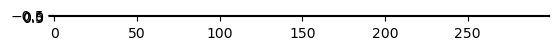

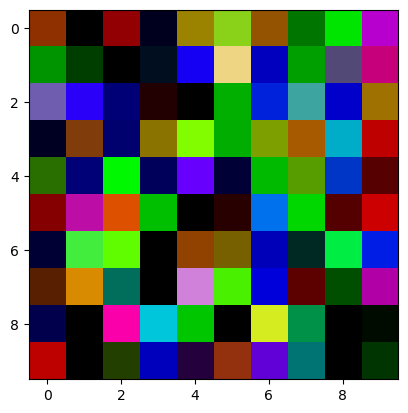

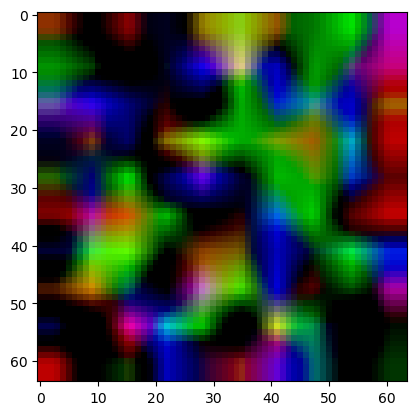

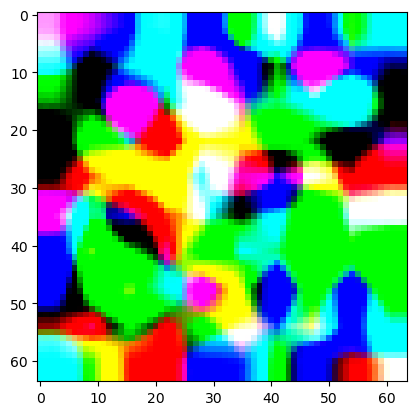

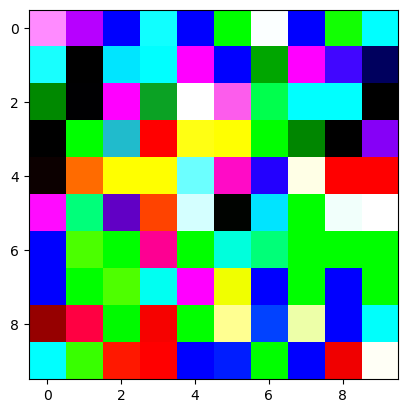

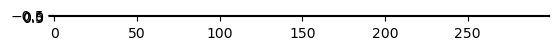

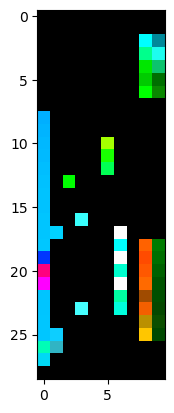

In [6]:
plt.imshow(noise.detach())
plt.show()

plt.imshow(noise_view[0].permute(1, 2, 0).detach())
plt.show()

plt.imshow(noise_reshape[0].permute(1, 2, 0).detach())
plt.show()

plt.imshow(out_test[0].permute(1, 2, 0).detach())
plt.show()

plt.imshow(latent_out[0].permute(1, 2, 0).detach())
plt.show()

plt.imshow(latent_out_view.detach())
plt.show()

plt.imshow(output[0].permute(1, 2, 0).detach())
plt.show()

In [25]:
output


tensor([[[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
            0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
            0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
            0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
            0.0000,  0.0000,  0.3074],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
            0.0000,  0.0000,  0.3800],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
            0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
            0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
            0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  6.2471,  0.0000,
            0.0000,  0